https://www.kaggle.com/code/moulibhaskar/pytorch-rice-classification/data

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets

import matplotlib.pyplot as plt
import numpy as np
import pathlib
import os

import copy
import random
import time

/usr/local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [3]:
path = '/Users/cassidy/rice-classification/Rice_Image_Dataset/new-dataset'

In [4]:
data_dir = pathlib.Path(path)
data_dir

PosixPath('/Users/cassidy/rice-classification/Rice_Image_Dataset/new-dataset')

In [5]:
arborio = list(data_dir.glob('Arborio/*'))[:1]
basmati = list(data_dir.glob('Basmati/*'))[:1]
ipsala = list(data_dir.glob('Ipsala/*'))[:1]
jasmine = list(data_dir.glob('Jasmine/*'))[:1]
karacadag = list(data_dir.glob('Karacadag/*'))[:1]

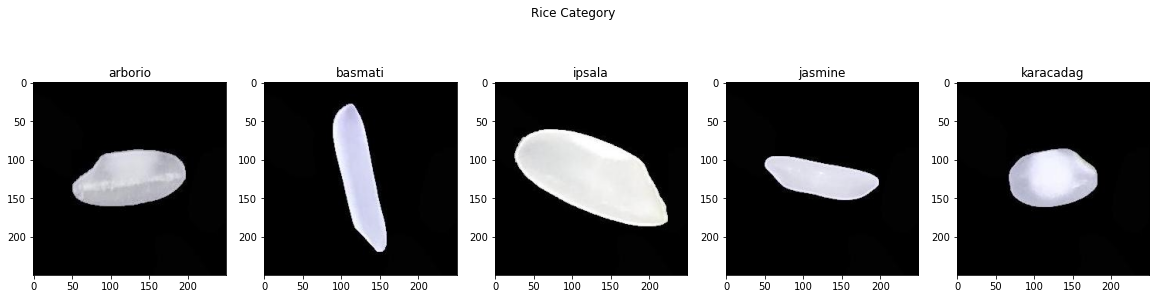

In [6]:
import matplotlib.image as img
fig, ax = plt.subplots(ncols = 5, figsize = (20,5))
fig.suptitle('Rice Category')
arborio_image = img.imread(arborio[0])
basmati_image = img.imread(basmati[0])
ipsala_image = img.imread(ipsala[0])
jasmine_image = img.imread(jasmine[0])
karacadag_image = img.imread(karacadag[0])

ax[0].set_title('arborio')
ax[1].set_title('basmati')
ax[2].set_title('ipsala')
ax[3].set_title('jasmine')
ax[4].set_title('karacadag')

ax[0].imshow(arborio_image)
ax[1].imshow(basmati_image)
ax[2].imshow(ipsala_image)
ax[3].imshow(jasmine_image)
ax[4].imshow(karacadag_image)

plt.show()

In [7]:
df_labels = {
    'Arborio' : 0,
    'Basmati' : 1,
    'Ipsala' : 2,
    'Jasmine' : 3,
    'Karacadag': 4
}

In [8]:
class_names = ['Karacadag', 'Basmati', 'Jasmine', 'Arborio', 'Ipsala']
num_class = len(class_names)

image_files = [[os.path.join(path, class_name, x) for x in os.listdir(os.path.join(path, class_name))] for class_name in class_names]

In [9]:
images_paths = []
for i in range(5):
    for j in range(len(image_files[i])):
        current = image_files[i]
        images_paths.append(current[j])

In [10]:
import random

random.shuffle(images_paths)

train_paths = images_paths[:2100]
test_paths = images_paths[2100:2350]
valid_paths = images_paths[2350:]

In [11]:
import torchvision.transforms as transforms

In [12]:
transformations = transforms.Compose(
    [
        transforms.Resize((256,256)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(30),
        transforms.ToTensor(),
        transforms.Normalize((0.5),(0.5))
    ]
)

In [13]:
from torch.utils.data import Dataset
from random import randint
from PIL import Image
class ImageDataset(Dataset):
    def __init__(self, df_labels, base_dir, transform=None):
        super().__init__()
    
        self.base_dir = base_dir
        self.df_labels = df_labels
        self.transform = transform
        
    def __len__(self):
        return len(self.base_dir)
    
    def __getitem__(self, index):
        
        image_path = self.base_dir[index]
        
        image = Image.open(image_path)
        
        label_name = image_path.split('/')[-2]
        
        label = self.df_labels[label_name]
        
        if self.transform is not None:
            image = self.transform(image)
        return (image, label)

In [14]:
train_data = ImageDataset(df_labels, train_paths, transformations)
test_data = ImageDataset(df_labels, test_paths, transformations)
valid_data = ImageDataset(df_labels, valid_paths, transformations)

In [15]:
from torch.utils.data import DataLoader
train_ds = DataLoader(train_data, batch_size = 64, shuffle = True)
val_ds = DataLoader(valid_data, batch_size = 64, shuffle = True)
test_ds = DataLoader(test_data, batch_size = 64, shuffle = True)

In [16]:
class LeNet(nn.Module):
    def __init__(self, output_dim):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels=3,
                               out_channels=6,
                               kernel_size=5)

        self.conv2 = nn.Conv2d(in_channels=6,
                               out_channels=16,
                               kernel_size=5)

        self.fc_1 = nn.Linear(16 * 61 * 61, 120)
        self.fc_2 = nn.Linear(120, 84)
        self.fc_3 = nn.Linear(84, output_dim)

    def forward(self, x):
        #(3, 256, 256) ---> input
        x = self.conv1(x) 
        #(6, 252, 252) ---> output
        x = F.max_pool2d(x, kernel_size=2)
        #(6, 126, 126)
        x = F.relu(x)
        x = self.conv2(x)
        #(16, 122, 122)
        x = F.max_pool2d(x, kernel_size=2)
        #(16, 61, 61)
        x = F.relu(x)
        x = x.view(x.shape[0], -1)
        h = x
        x = self.fc_1(x)
        x = F.relu(x)
        x = self.fc_2(x)
        x = F.relu(x)
        x = self.fc_3(x)
       
        
        return x, h

In [17]:
OUTPUT_DIM = 5
model = LeNet(OUTPUT_DIM)

In [18]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 7,157,901 trainable parameters


In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [20]:
model = model.to(device)

In [21]:
from torch.optim import Adam 

In [22]:
optimizer = Adam(model.parameters(), lr = 0.001)
loss_fun = F.cross_entropy

In [23]:
loss_train = []
acc_train = []
loss_val = []
acc_val = []

def train(model, epoch, train_ds):
    model.train()
    total_num = len(train_ds.dataset)
    train_loss = 0
    correct_num = 0

    for image, label in train_ds:
        image = image.to(device)
        label = label.to(device)
        # Convert the tag from int32 type to long type, otherwise the calculation loss will report an error
        label = label.to(torch.long)

        output,_ = model(image)
        loss = loss_fun(output, label)
        train_loss += loss.item() * label.size(0)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        predict = torch.argmax(output, dim=-1)
        correct_num += label.eq(predict).sum()

    train_loss = train_loss / total_num
    train_acc = correct_num / total_num
    print('epoch: {} --> train_loss: {:.6f} - train_acc: {:.6f} - '.format(
        epoch, train_loss, train_acc), end='')
    
    loss_train.append(train_loss)
    acc_train.append(train_acc)
    

def evaluate(model, eval_ds, mode='val'):
    model.eval()

    total_num = len(eval_ds.dataset)
    eval_loss = 0
    correct_num = 0

    for image, label in eval_ds:
        image = image.to(device)
        label = label.to(device)
        label = label.to(torch.long)
        
        output,_ = model(image)
        loss = loss_fun(output, label)
        eval_loss += loss.item() * label.size(0)

        predict = torch.argmax(output, dim=-1)
        correct_num += label.eq(predict).sum()
    
    eval_loss = eval_loss / total_num
    eval_acc = correct_num / total_num
    
    print('{}_loss: {:.6f} - {}_acc: {:.6f}'.format(
        mode, eval_loss, mode, eval_acc))
    
    loss_val.append(eval_loss)
    acc_val.append(eval_acc)


In [25]:
for epoch in range(5):
    train(model, epoch, train_ds)
    evaluate(model, val_ds)

epoch: 0 --> train_loss: 0.348852 - train_acc: 0.889524 - val_loss: 0.385942 - val_acc: 0.800000
epoch: 1 --> train_loss: 0.171093 - train_acc: 0.936667 - val_loss: 0.098183 - val_acc: 0.960000
epoch: 2 --> train_loss: 0.121526 - train_acc: 0.955238 - val_loss: 0.077174 - val_acc: 0.966667
epoch: 3 --> train_loss: 0.083975 - train_acc: 0.971429 - val_loss: 0.024736 - val_acc: 0.993333
epoch: 4 --> train_loss: 0.056167 - train_acc: 0.978571 - val_loss: 0.061933 - val_acc: 0.973333


In [65]:
pred = []
actual = []

def test(model, eval_ds, mode='val'):
    model.eval()

    total_num = len(eval_ds.dataset)
    eval_loss = 0
    correct_num = 0  

    for image, label in eval_ds:
        image = image.to(device)
        label = label.to(device)
        label = label.to(torch.long)
        
        output,_ = model(image)
        loss = loss_fun(output, label)
        eval_loss += loss.item() * label.size(0)

        predict = torch.argmax(output, dim=-1)
        correct_num += label.eq(predict).sum()
        
        pred.append(predict.numpy())
        actual.append(label.numpy())
    
    eval_loss = eval_loss / total_num
    eval_acc = correct_num / total_num
    
    print('{}_loss: {:.6f} - {}_acc: {:.6f}'.format(
        mode, eval_loss, mode, eval_acc))
    
    loss_val.append(eval_loss)
    acc_val.append(eval_acc)
    
    return pred, actual

In [66]:
y_pred, y = test(model, test_ds, mode='test')

test_loss: 0.100187 - test_acc: 0.968000


In [34]:
loss_val.pop()

0.08778621548414231

In [31]:
acc_val.pop()

tensor(0.9600)

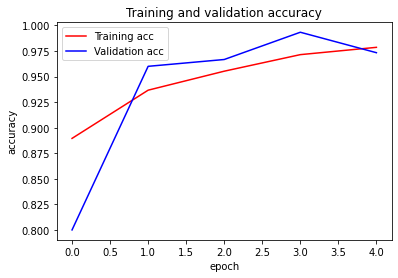

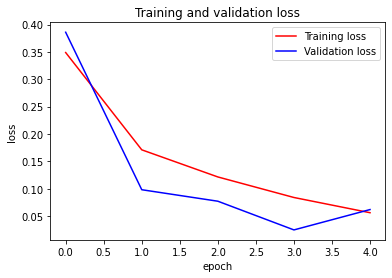

In [36]:
epochs = [0,1,2,3,4]

plt.plot(epochs, acc_train, 'r', label='Training acc')
plt.plot(epochs, acc_val, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.ylabel('accuracy') 
plt.xlabel('epoch')
plt.legend()
plt.figure()

plt.plot(epochs, loss_train, 'r', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('loss') 
plt.xlabel('epoch')
plt.legend()
plt.show()

In [90]:
import itertools
from sklearn.metrics import confusion_matrix

def draw_confusion_matrix(y, yhat, classes):
    '''
        Draws a confusion matrix for the given target and predictions
        Adapted from scikit-learn and discussion example.
    '''
    plt.cla()
    plt.clf()
    matrix = confusion_matrix(y, yhat)
    plt.imshow(matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()
    num_classes = len(classes)
    plt.xticks(np.arange(num_classes), classes, rotation=90)
    plt.yticks(np.arange(num_classes), classes)
    
    fmt = 'd'
    thresh = matrix.max() / 2.
    for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):
        plt.text(j, i, format(matrix[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if matrix[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

In [44]:
import tensorflow as tf

In [92]:
y_new = []

for batch in y:
    for i in batch:
        y_new.append(batch[i])

y = y_new

In [93]:
y_pred_new = []

for batch in y_pred:
    for i in batch:
        y_pred_new.append(batch[i])
        
y_pred = y_pred_new

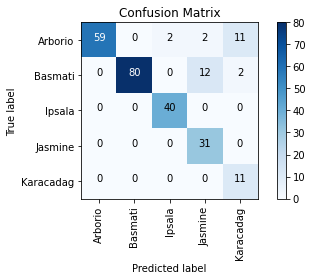

In [94]:
classes = ['Arborio','Basmati','Ipsala','Jasmine','Karacadag']

draw_confusion_matrix(y_new, y_pred_new, classes)